# Corpus clustering based on motifs features

**Goal**: Find natural and interpretable clusters in a corpus based on motifs.

## Methodology

Our feature space is very large (more than 200K) on top TFIDF features are not gaussian. Thus, we can expect KMeans to perform very badly on the raw table.

We propose to use a manifold learning techning, TSNE, to reduce the dimension of the feature spaces. TSNE helps use to visualize potential clusters in the dataset. We then apply a clustering algorithm, DBSCAN, to find the cluster in the embedding space.

# Import librairies

In [1]:
from gensim import corpora
from gensim import models
from gensim.matutils import corpus2csc

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

from sklearn.preprocessing import normalize
from motifs.cluster import Cluster
from sklearn import metrics

from motifs.dataloader import CanonData
from motifs.plots import silhouette_plot, plot_clusters, scatter_plot_one_cluster
from motifs.utils import filter_token_by_freq

# Load data

- Get metadata
- Load the 5-grams that were precomputed using a subcorpus of the "canon" corpus.
    - This subcorpus was built by selecting at most 50 texts at random per period, which are defined in `motifs.dataloader.CanonData`, e.g 1800-1826, 1827-1850, 1851-1869, 1870-1899, 1900-1945, 1946-2024.
    - We have in total 217 documents
    - Remove tokens that appear only once in each document in the corpus

In [2]:
NGRAMS_PATH = "/Users/brunospilak/Documents/Sorbonne/PyMotifs/data_backup/ngrams_canon.csv"
METADATA_PATH = "../data/canon/metadata.csv"

In [3]:
# Load 5-grams, about 1.6GB
ngrams = pd.read_csv(NGRAMS_PATH, index_col=0)
docs = sorted(list(set(ngrams.doc.unique())))

# Remove tokens that appear only once, this can take a while since ngrams has more than 15 Million rows
t1 = time.time()
ngrams = filter_token_by_freq(ngrams, 1, groupby="doc")
t2 = time.time()
print(f"Done in {t2-t1:.2f} secs")

Done in 84.69 secs


In [4]:
# Get the metadata for the subcorpus
metadata = CanonData(METADATA_PATH, ids=docs)

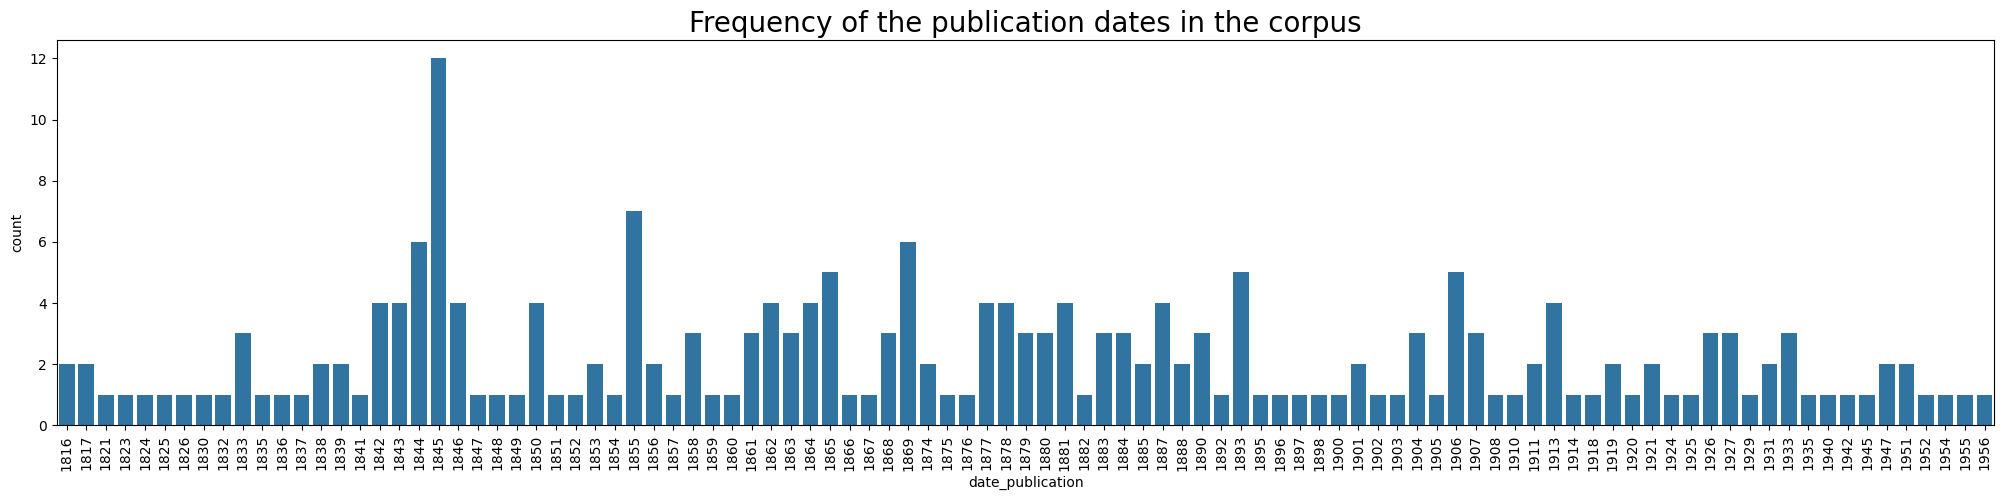

In [5]:
plt.figure(figsize=(25,5))
sns.barplot(metadata.data["date_publication"].value_counts())
plt.xticks(rotation=90)
plt.title("Frequency of the publication dates in the corpus", size=20)
plt.show()

# TFIDF

Now, compute TFIDF and store them in a sparse matrix.

Note: **We use Gensim to compute the TFIDF. Gensim normalizes the tfidf vectors by default. However, as we do not select all dimensions in the vector, we do not normalize the vector directly, we will do it after feature selection.**

We use a very simple feature selection method. We keep only the less sparse features, for example the first $n$ features ($n=10000$). As a measure for sparsity, we simply compute the frequency of non-zeros elements: the larger the frequency, the less sparse the feature is.

In [6]:
# Create a generator
def get_corpus():
    return (ngrams[ngrams["doc"] == d]["token"].tolist() for d in docs)

# Create dictionary with gensim
t1 = time.time()
dictionary = corpora.Dictionary(get_corpus())
# Get Bag of words representation
bow_corpus = [dictionary.doc2bow(text) for text in get_corpus()]
# Fit the tfidf
model = models.TfidfModel(bow_corpus, normalize=False)
mat_tfidf = corpus2csc([model[d] for d in bow_corpus]).T
t2 = time.time()
print(f"Done in {t2-t1:.2f} secs")

# Below is only used for reproducibility as gensim does not order the tokens
dictionary[0]
columns = list(dictionary.id2token.values())
order_ = np.argsort(columns)
mat_tfidf = mat_tfidf[:, order_]
columns = np.array(columns)[order_].tolist()

Done in 99.67 secs


In [7]:
# Keep the n less sparse features
n = 10000
freq_nonzeros = np.asarray(np.sum(mat_tfidf != 0, axis=0) / mat_tfidf.shape[0])[0]
selected = np.argsort(freq_nonzeros)[-n:]
features = mat_tfidf[:,selected]

# Save names of columns and indices
index=docs
columns = list({id_: dictionary[id_] for id_ in selected})
features.shape

(217, 10000)

# Clustering

We have 10000 features and 217 documents. The features are TFIDF features, thus definitely not gaussian. We can expect KMeans to perform very badly on the raw table. On top, we can suspect non-linear relationship between the documents.

We propose to use a manifold learning techning, TSNE, to reduce the dimension of the feature spaces. TSNE helps use to visualize potential clusters in the dataset.


**note: TSNE is not deterministic even when setting random_state. The results might look different across multiple runs. It is worth testing the sensitivity of the intrepretation with various random_state. We noticed quite stable results for the Balzac, Verne, and Delly clusters.**

For reproducibility, you can save the embedding once and reload it.

The model was created using the following parameters:
```
projection = {
    "name": "TSNE",
    "params": {
        "n_components": 2,
        "random_state": 42,
        "init": "random",
        "perplexity": 5,
    }
}
cluster = {
    "name": "DBSCAN",
    "params": {"eps": 4, "min_samples": 5, "metric": "euclidean"}
}
```
The minimum size of a cluster is set to 5 documents to found a reasonable amount of clusters
eps depends on the distance between points in the embedding space
We could tune these parameters using a criterion, for example the Silhouette score. We do not do that here.

117.64
[ 0  5  0  0  3 -1 -1 -1  3 -1  1  5  2  3  3  3  3  3 -1  3 -1 -1  4 -1
  4  4  4  5  4  4  4  4  4  4  4  4  4  4  4 -1 -1  3  5  3 -1  4  4  1
  1  1  3  1  1 -1  6  3  6  7  5  1  1  1  4  4 -1  3  5 -1  0  7 -1  3
  3  1  1  1  1  1  6  1  5 -1 -1  3 -1  3  6  7  2 -1  3  5  2  1  8  1
  7  7  3  5  3  3  7  7  5  7  3  2  1  3  8  1  1  1  5  7  5  3  9  7
  2  7  7  2 -1 -1  7  1  9  5  2  5  9 -1  7  2  2  2  1  3 -1 -1  8 -1
  9  2 -1  2  2  3 -1  9  2  1  1  3  9 -1 -1  2  1 -1 -1  0  3  8  3  3
  3  7  9  6  2  2 10  8 -1 -1  3  2  3  3 -1 -1 -1 -1  7  9  1  3  3 10
 -1 10  2 -1  3  2 -1 -1 10  1 10 -1 -1 -1 10  3 10  7  3 10 10 10 -1 10
 -1]


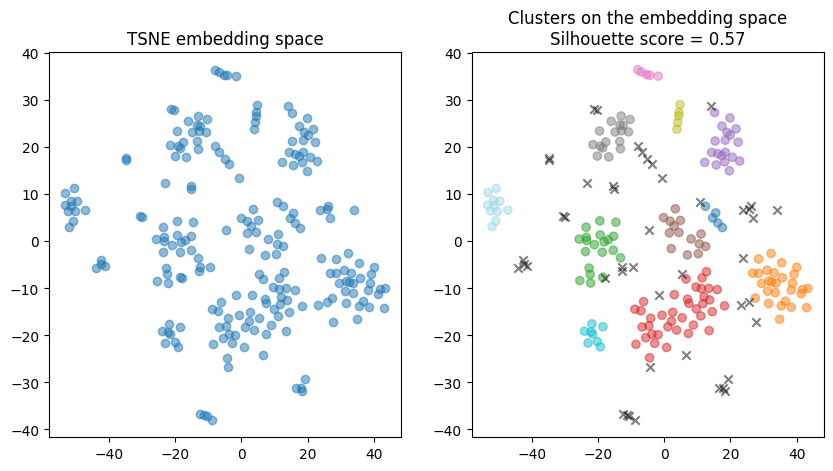

In [8]:
# This cell can take a while to run ≈ 2min
X = normalize(features, norm='l2', axis=1)

cluster = Cluster(projection="TSNE", cluster="DBSCAN")
t1 = time.time()
cluster_labels = cluster.fit_predict(X)
t2 = time.time()
print(f"{t2-t1:.2f}")
print(cluster_labels)

cluster.plot()

We can observe some clusters on the left plot. We observe that DBSCAN found 11 clusters, the grey cross points being classified as noise. However, we could probably have found more clusters of small sizes by decreasing the minimum cluster size.

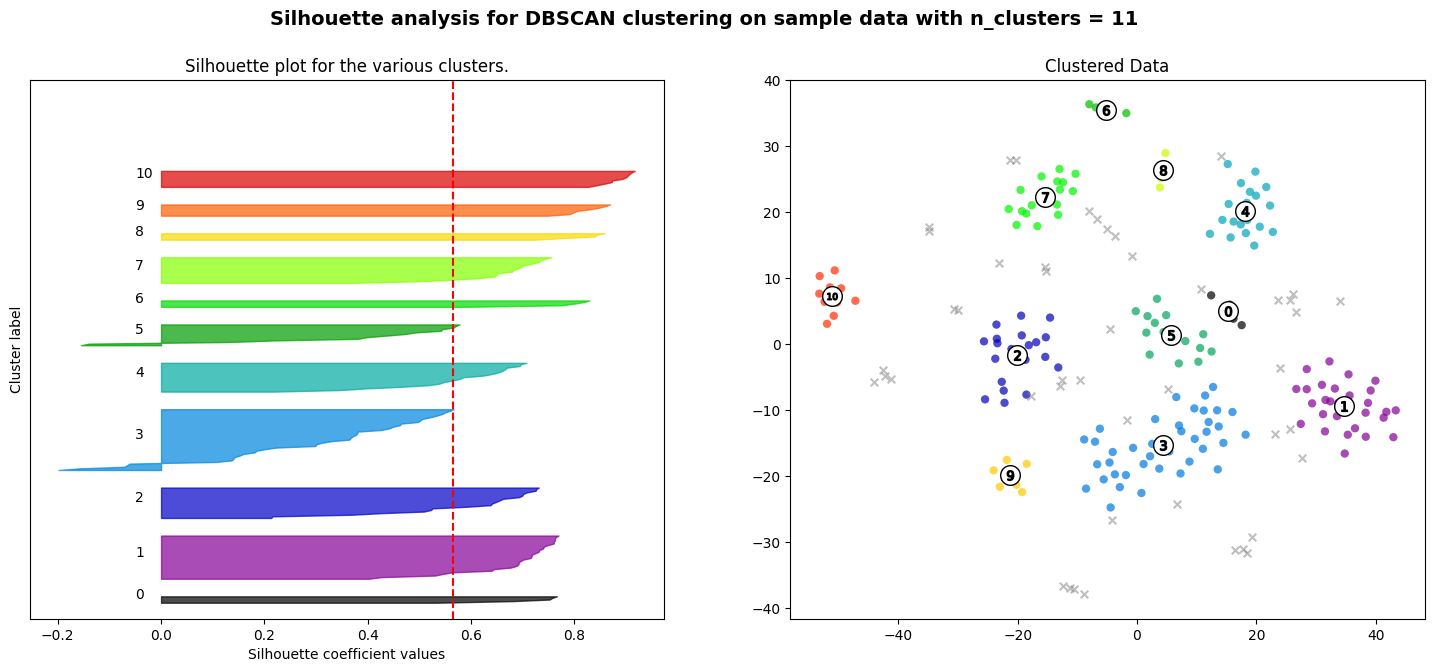

In [9]:
sample_silhouette_values = silhouette_plot(cluster.embedding, cluster_labels)

From the silhouette plot above, we observe that the a part from cluster 3 and 5, all clusters are quite dense with respect to the Euclidean distance. A few negative silhouette scores in cluster 3 and 5 indicate that some samples in these clusters might belong to another one or should be classified as noise. From the thickness of the silhouette, we deduce that cluster 3 is the largest cluster and it might contain hetereogenous samples.
However the other clusters are quite dense and the average silhouette score of 0.57 shows that the clusters found by DBSCAN are well defined with respect to the euclidean distance.
Let us confirm this by looking into the constitutions of the clusters.

In [10]:
clusters = {str(c): [] for c in cluster_labels}
for i, d in enumerate(docs):
    clusters[str(cluster_labels[i])].append(d)
# Save the clusters
# json.dump(clusters, aopen("clusters.json", "w"))
clusters

{'0': ['1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge-de-l-Indostan-ou-les-Portugais-au-Malabar-Tome-4',
  '1817_Barthelemy-Hadot-Marie-Adelaide_Les-Venitiens-ou-le-Capitaine-français-Tome-2',
  '1817_Barthelemy-Hadot-Marie-Adelaide_Les-venitiens-ou-Le-capitaine-français-Tome-1',
  '1855_Stendhal_Chroniques-italiennes',
  '1903_Leblanc-Maurice_Un-gentleman'],
 '5': ['1816_Bournon-Malarme-Charlotte-de_Lancelot-Montagu-ou-le-Resultat-des-bonnes-fortunes-Tome-2',
  '1833_Corbiere-Edouard_La-mer-et-les-marins-Scenes-maritimes',
  '1843_Pigault-Lebrun_Mon-oncle-Thomas',
  '1845_Sue-Eugene_La-coucaratcha-Tome-I',
  '1853_Sand-George_La-fauvette-du-docteur',
  '1855_Sand-George_Kourroglou',
  '1862_Dumas-Alexandre_La-princesse-Flora',
  '1865_Aimard-Gustave_Le-Montonero',
  '1869_Gautier-Judith_Le-Dragon-Imperial',
  '1874_Colomb-Josephine_La-Fille-de-Cariles-Le-petit-prince-Ulrich-Nedji-la-Bohemienne-La-bonne-Mitche',
  '1877_Malot-Hector_Comte-du-Pape',
  '1878_Gaboriau-Emile_Le-capitain

# Clusters interpretation based on the metadata

In [11]:
metadata.data["cluster"] = cluster_labels

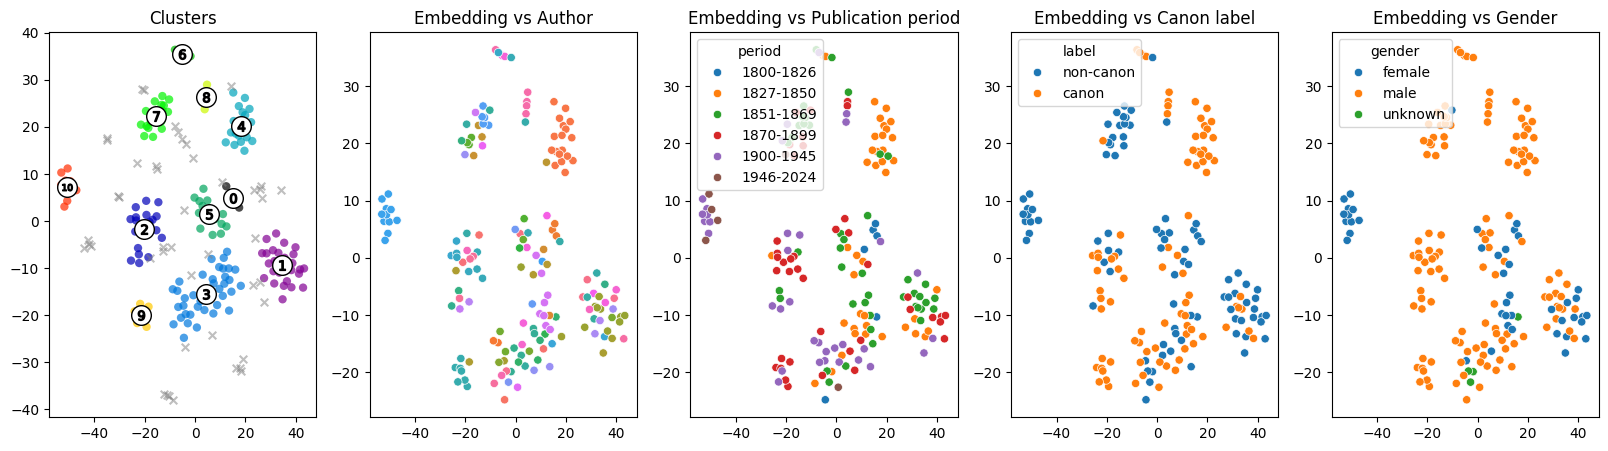

In [12]:
fig, axs = plt.subplots(1, 5, figsize=(20,5))
# Cluters
plot_clusters(cluster.embedding, cluster_labels, ax=axs[0], title="Clusters")

# Author
sns.scatterplot(x=cluster.embedding[cluster_labels!=-1,0], y=cluster.embedding[cluster_labels!=-1,1], 
                hue=metadata.data.loc[cluster_labels!=-1, "author"], legend=False, ax=axs[1])
axs[1].set_title("Embedding vs Author")
# Date
sns.scatterplot(x=cluster.embedding[cluster_labels!=-1,0], y=cluster.embedding[cluster_labels!=-1,1], 
                hue=metadata.data.loc[cluster_labels!=-1, "period"], ax=axs[2])
axs[2].set_title("Embedding vs Publication period")

# Etiquette
sns.scatterplot(x=cluster.embedding[cluster_labels!=-1,0], y=cluster.embedding[cluster_labels!=-1,1], 
                hue=metadata.data.loc[cluster_labels!=-1, "label"], ax=axs[3])
axs[3].set_title("Embedding vs Canon label")

# Gender
sns.scatterplot(x=cluster.embedding[cluster_labels!=-1,0], y=cluster.embedding[cluster_labels!=-1,1], 
                hue=metadata.data.loc[cluster_labels!=-1, "gender"], ax=axs[4])
axs[4].set_title("Embedding vs Gender")

plt.show()

From the plot above, it seems that the author variable can help interpret the cluster. Indeed, clusters 0, 4 8, 6, and 10 seem to roughly correspond to one author. The publication date, canon label, and gender are dependent on the author.

On top, out of the 113 different authors reprensented in the corpus only 11 have texts groupped in different clusters. This is shown in the output below listing the clusters that have authors in common. For example, both cluster 1 and 3 contain texts written by Apollinaire.

In [13]:
labels = list(set(cluster_labels[cluster_labels != -1]))
pairs = [(a, b) for idx, a in enumerate(labels) for b in labels[idx + 1:]]
authors_overlap = {}
authors_overlap_id = []
for p in pairs:
    o = set(metadata.data.loc[cluster_labels==p[0], "author"]).intersection(
        set(metadata.data.loc[cluster_labels==p[1], "author"])
    )
    if len(o) > 0:
        authors_overlap[p] = o
        authors_overlap_id.extend(list(o))
print(len(set(authors_overlap_id)))
authors_overlap



11


{(0, 1): {'Leblanc, Maurice'},
 (0, 2): {'Leblanc, Maurice'},
 (1, 2): {'Leblanc, Maurice'},
 (1, 3): {'Fleuriot, Zénaïde', 'unknown'},
 (1, 5): {'Dumas (père), Alexandre'},
 (2, 3): {'Apollinaire, Guillaume'},
 (2, 6): {'Maricourt, René Du Mesnil'},
 (2, 9): {'Daudet, Alphonse'},
 (3, 5): {'Sand, George', 'Sue, Eugène'},
 (3, 6): {'Sue, Eugène'},
 (3, 7): {'Renard, Maurice'},
 (5, 6): {'Sue, Eugène'},
 (6, 8): {'Verne, Jules'}}

## Contingency table

Another usefull statistics for categorical variables are contingency table. For example, we can ask ourselves: *What is the probability that a document in cluster $j$ is written by author $i$?*, *What is the probability that a document written by author $i$ is located in cluster $j$?*, *What is the probability that a document is written by a female in cluster $i$?* etc.


#### Author vs Cluster

In [14]:
crosstab_cluster_y = pd.crosstab(metadata.data["author"], metadata.data["cluster"])
crosstab_cluster_y

cluster,-1,0,1,2,3,4,5,6,7,8,9,10
author,,,,,,,,,,,,
"About, Edmond",0,0,2,0,0,0,0,0,0,0,0,0
"Aimard, Gustave",0,0,0,0,0,0,1,0,0,0,0,0
"Albalat, Antoine",0,0,0,1,0,0,0,0,0,0,0,0
"Apollinaire, Guillaume",0,0,0,1,1,0,0,0,0,0,0,0
"Arlincourt, Charles-Victor Prévost d'",0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
"Verne, Jules",0,0,0,0,0,0,0,1,0,4,0,0
"Vesco, Marie Delorme, Mme Léon",0,0,1,0,0,0,0,0,0,0,0,0
"Villiers de l'Isle-Adam, Auguste",1,0,0,0,1,0,0,0,0,0,0,0


**What is the probability that a document in cluster $i$ is written by Balzac?**

*95%* in cluster 4. Knowing that Balzac represents 10% of the documents in the corpus, we can say that Balzac is clearly overrepresented in cluster 4.

In [15]:
# Sum by columns (clusters)
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=0).values.reshape(1,-1)) * 100
df.loc[["Balzac, Honoré de"]].style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8,9,10
author,,,,,,,,,,,,
"Balzac, Honoré de",7,0,0,0,0,95,0,0,0,0,0,0


**What is the probability that a document written by Balzac belongs to cluster $i$?**

Cluster 5 representes *86%* of Balzac texts.

In [16]:
# Sum by row (author)
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=1).values.reshape(-1,1)) * 100
df.loc[["Balzac, Honoré de"]].style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8,9,10
author,,,,,,,,,,,,
"Balzac, Honoré de",14,0,0,0,0,86,0,0,0,0,0,0


We can already say that cluster 4 mostly represent Balzac style as 86% of Balzac texts are grouped within this cluster and 95% of the documents belonging to cluster 4 are written by Balzac.

#### Gender vs Cluster

In [17]:
crosstab_cluster_y = pd.crosstab(metadata.data["gender"], metadata.data["cluster"])
crosstab_cluster_y

cluster,-1,0,1,2,3,4,5,6,7,8,9,10
gender,,,,,,,,,,,,
female,8,3,13,0,9,0,6,0,1,0,0,11
male,38,2,15,20,26,19,8,5,16,5,8,0
unknown,0,0,0,0,4,0,0,0,0,0,0,0


**What is the probability that a document in cluster $i$ is written by Female?**

100% for cluster 10.

In [18]:
# Sum by columns (clusters)
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=0).values.reshape(1,-1)) * 100
df.loc[["female"]].style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8,9,10
gender,,,,,,,,,,,,
female,17,60,46,0,23,0,43,0,6,0,0,100


**What is the probability that a document written by a female belongs to cluster $i$?**

Cluster 1 represents *25%* of the texts written by female authors.

In [19]:
# Sum by row (author)
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=1).values.reshape(-1,1)) * 100
df.loc[["female"]].style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8,9,10
gender,,,,,,,,,,,,
female,16,6,25,0,18,0,12,0,2,0,0,22


# Publication date vs Cluster

In [20]:
crosstab_cluster_y = pd.crosstab(metadata.data["period"], metadata.data["cluster"])
crosstab_cluster_y = crosstab_cluster_y.set_index(
    metadata.periods["start"].astype(str) + " - " + metadata.periods["end"].astype(str)
)

In [21]:
crosstab_cluster_y.sum(axis=1)/sum(crosstab_cluster_y.sum(axis=1))

1800 - 1826    0.041475
1827 - 1850    0.230415
1851 - 1869    0.230415
1870 - 1899    0.230415
1900 - 1945    0.230415
1946 - 2024    0.036866
dtype: float64

**What is the probability that a document in cluster $i$ was published at a given date?**

In cluster 7, 47% of the texts were published between 1851 and 1869 which is omre than 2 times larger than in the corpus. This period is overrepresented in this cluster.

In [22]:
# Sum by columns (clusters)
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=0).values.reshape(1,-1)) * 100
df.style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8,9,10
1800 - 1826,7,60,0,0,5,0,7,0,0,0,0,0
1827 - 1850,20,0,21,5,28,89,29,40,0,0,0,0
1851 - 1869,15,20,43,15,23,11,36,40,47,20,0,0
1870 - 1899,22,0,25,50,13,0,29,0,35,40,75,0
1900 - 1945,33,20,11,30,28,0,0,20,12,40,25,64
1946 - 2024,4,0,0,0,3,0,0,0,6,0,0,36


**What is the probability that a document published at a given date belongs to cluster $i$?**

More than a quarter of the texts that were published between 1851 and 1869 belongs to cluster 1. This is the largest score.

In [23]:
# Sum by columns (clusters)
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=1).values.reshape(-1,1)) * 100
df.style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8,9,10
1800 - 1826,33,33,0,0,22,0,11,0,0,0,0,0
1827 - 1850,18,0,12,2,22,34,8,4,0,0,0,0
1851 - 1869,14,2,24,6,18,4,10,4,16,2,0,0
1870 - 1899,20,0,14,20,10,0,8,0,12,4,12,0
1900 - 1945,30,2,6,12,22,0,0,2,4,4,4,14
1946 - 2024,25,0,0,0,12,0,0,0,12,0,0,50


## Cluster interpretation with respect to authors

We only consider the clusters with non-negative Silhouette score:

**Cluster 0**

Cluster 0 is a mixed between writings from Barthélemy-Hadot, Leblanc and Stendhal.

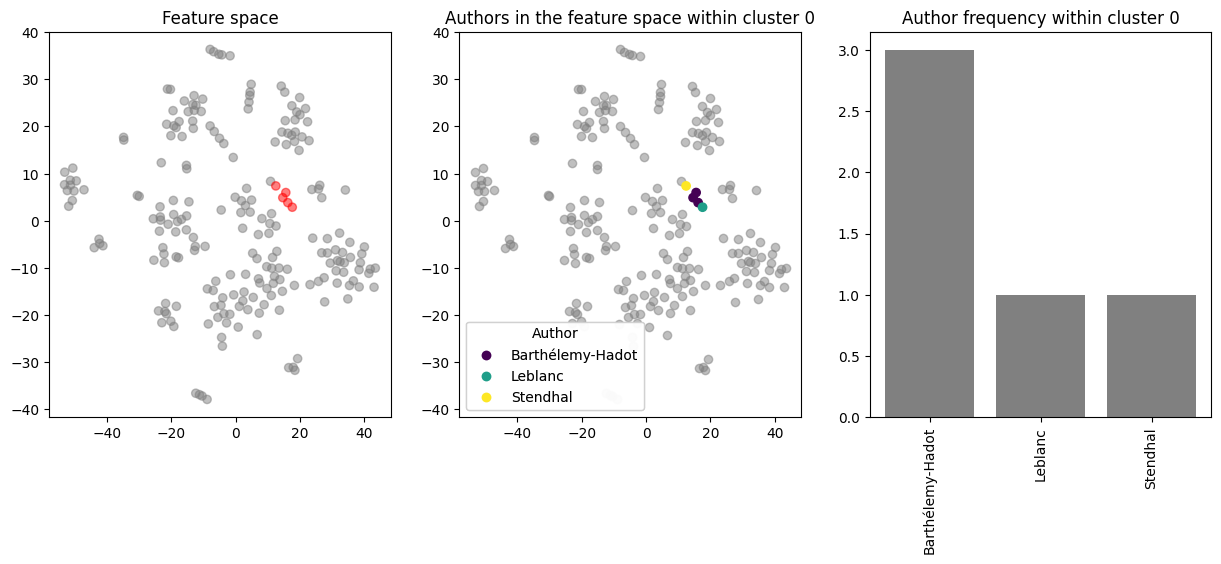

In [25]:
scatter_plot_one_cluster(cluster.embedding, cluster_labels, 0, metadata.data.loc[:, "author"])

**Cluster 1, 2, 3, 5, 7**
are difficult to interpret with the author variable. However only 8 authors out of 81 have documents grouped in different clusters. Thus, it is faire to say that the author variable help explaining the separation between these clusters.

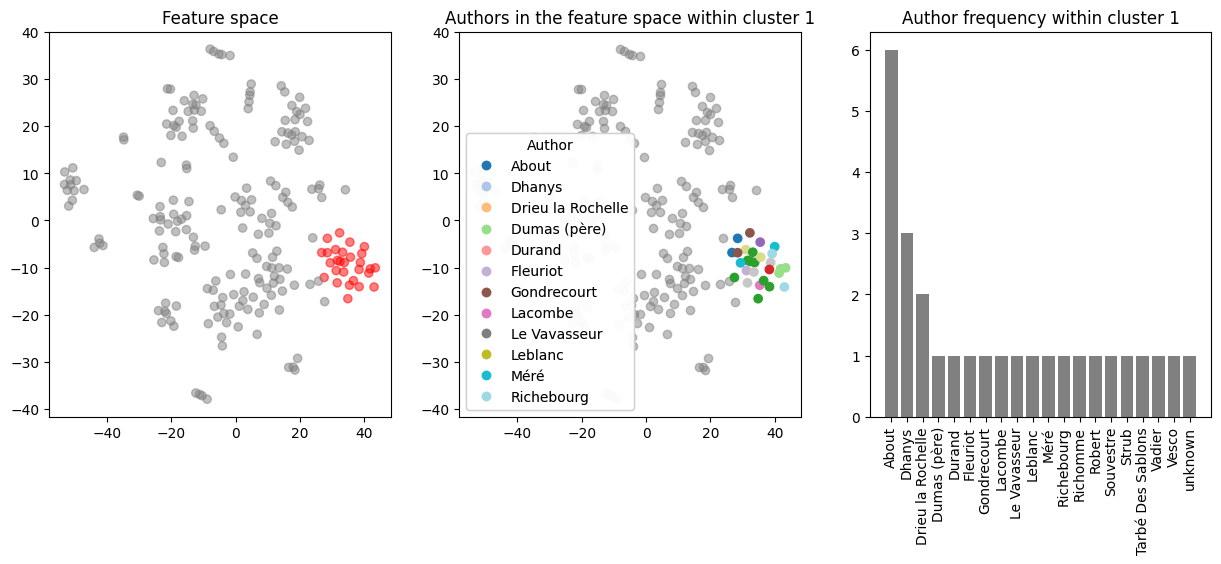

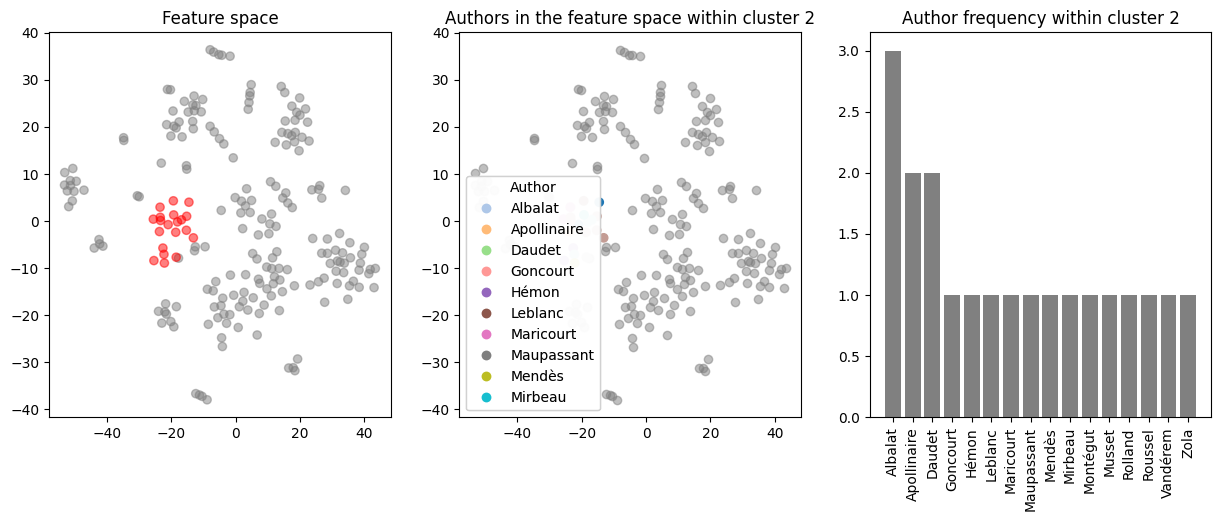

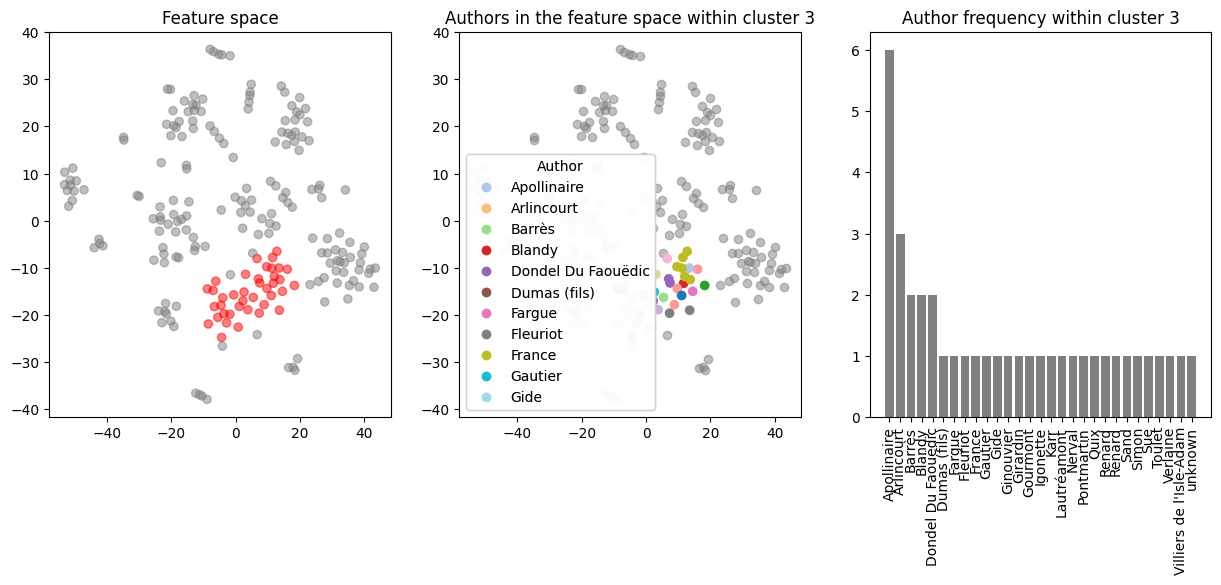

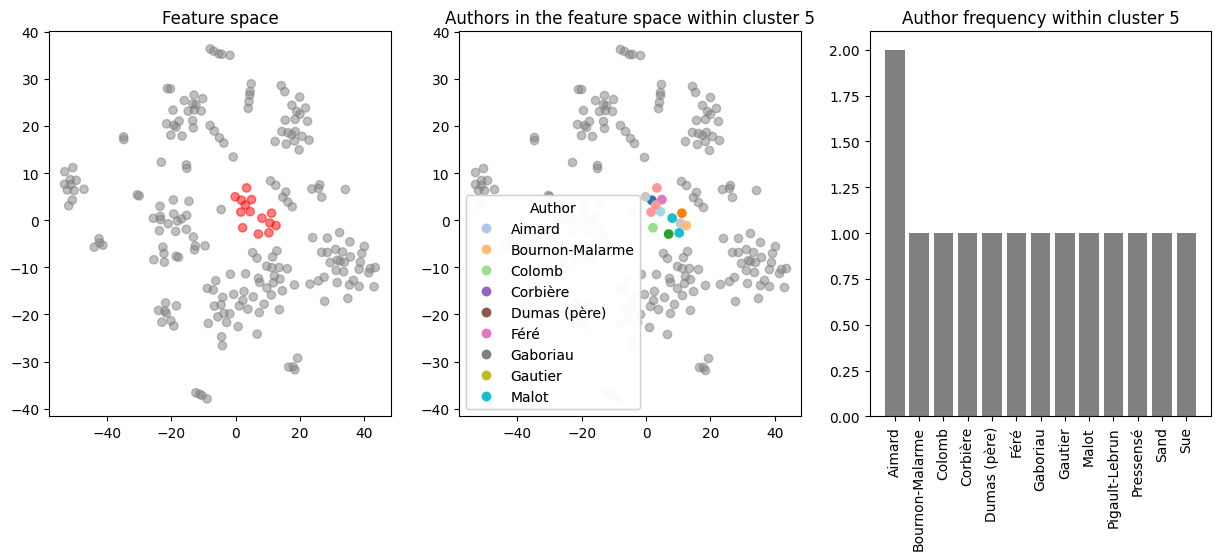

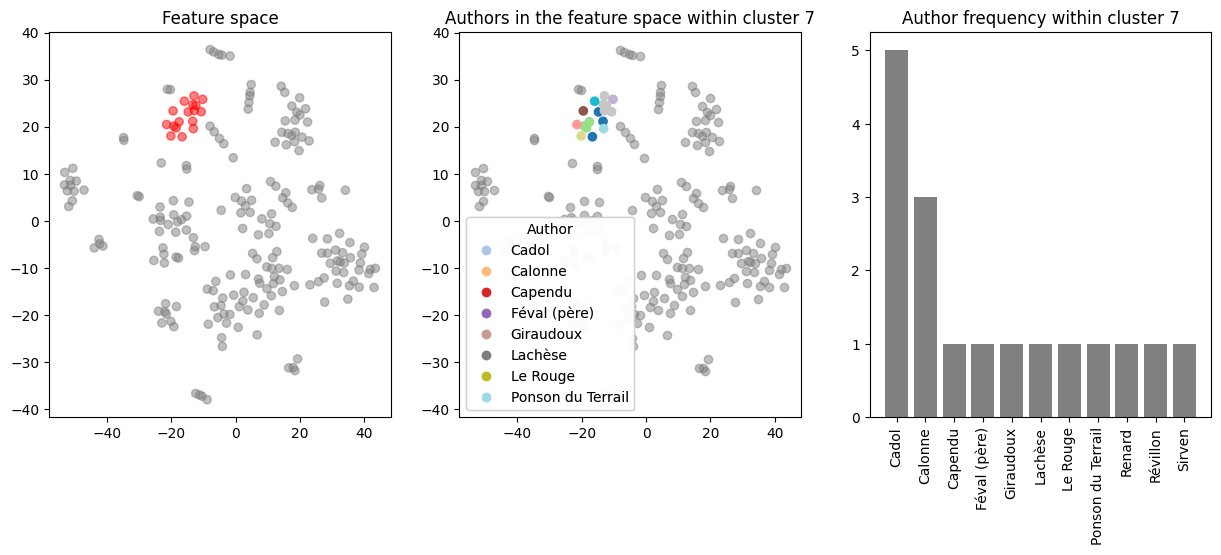

In [26]:
scatter_plot_one_cluster(cluster.embedding, cluster_labels, 1, metadata.data.loc[:, "author"])
scatter_plot_one_cluster(cluster.embedding, cluster_labels, 2, metadata.data.loc[:, "author"])
scatter_plot_one_cluster(cluster.embedding, cluster_labels, 3, metadata.data.loc[:, "author"])
scatter_plot_one_cluster(cluster.embedding, cluster_labels, 5, metadata.data.loc[:, "author"])
scatter_plot_one_cluster(cluster.embedding, cluster_labels, 7, metadata.data.loc[:, "author"])

In [27]:
labels = [1, 2, 3, 5, 7]
pairs = [(a, b) for idx, a in enumerate(labels) for b in labels[idx + 1:]]
authors_overlap = {}
authors_overlap_id = []
for p in pairs:
    o = set(metadata.data.loc[cluster_labels==p[0], "author"]).intersection(
        set(metadata.data.loc[cluster_labels==p[1], "author"])
    )
    if len(o) > 0:
        authors_overlap[p] = o
        authors_overlap_id.extend(list(o))
print(len(set(authors_overlap_id)))
print(authors_overlap)
print(len(set(metadata.data.loc[[i in labels for i in cluster_labels], "author"])))

8
{(1, 2): {'Leblanc, Maurice'}, (1, 3): {'Fleuriot, Zénaïde', 'unknown'}, (1, 5): {'Dumas (père), Alexandre'}, (2, 3): {'Apollinaire, Guillaume'}, (3, 5): {'Sue, Eugène', 'Sand, George'}, (3, 7): {'Renard, Maurice'}}
81


**Cluster 4**

Cluster 4 represents Balzac.

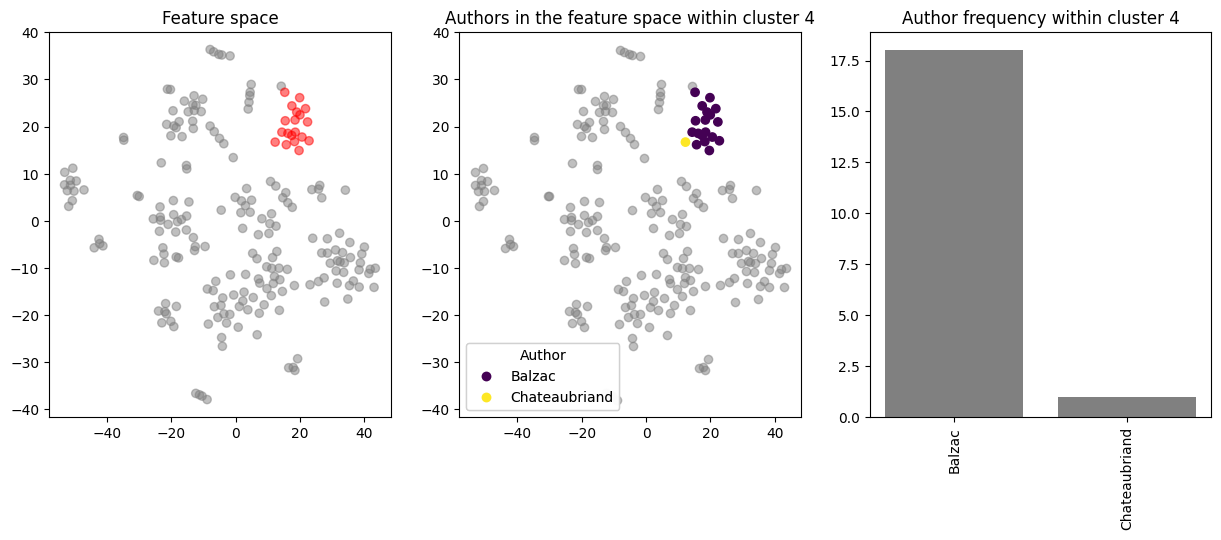

In [28]:
scatter_plot_one_cluster(cluster.embedding, cluster_labels, 4, metadata.data.loc[:, "author"])

**Cluster 8** mostly represents writings from Jules Verne.

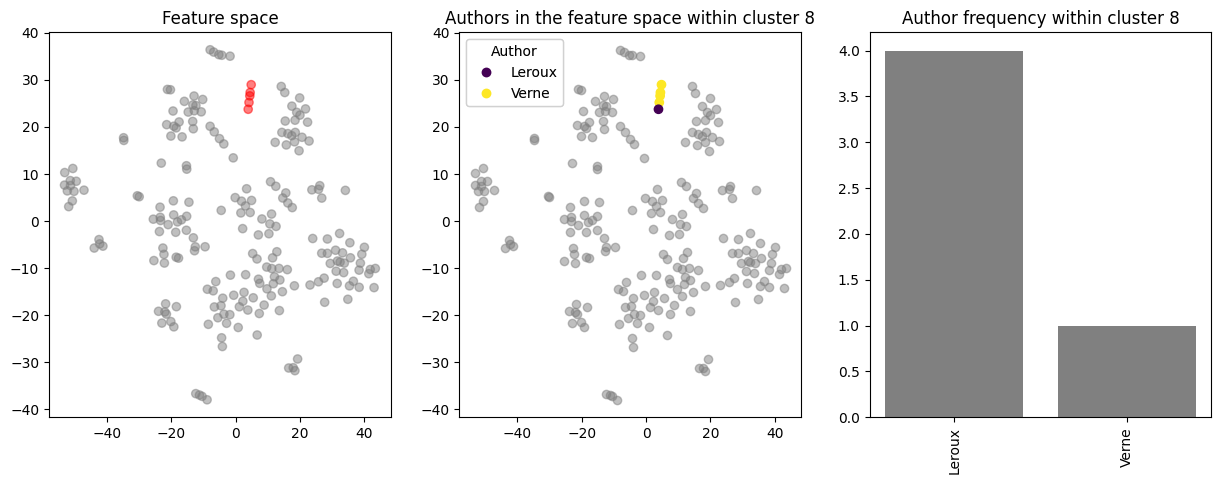

In [29]:
scatter_plot_one_cluster(cluster.embedding, cluster_labels, 8, metadata.data.loc[:, "author"])

**Cluster 9** mostly represents writings from Loti.

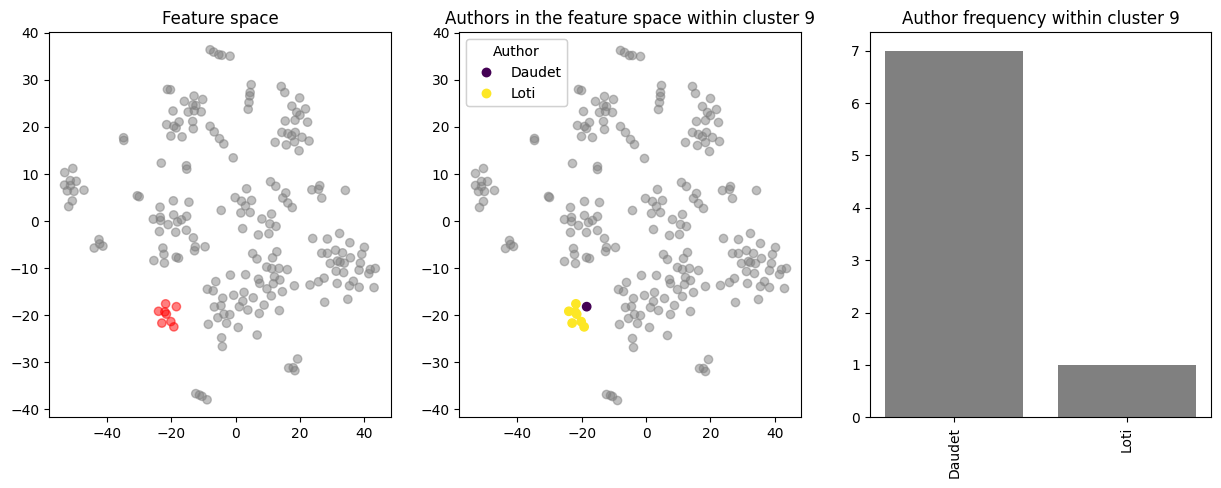

In [30]:
scatter_plot_one_cluster(cluster.embedding, cluster_labels, 9, metadata.data.loc[:, "author"])

**Cluster 10** mostly represent writings from Delly.

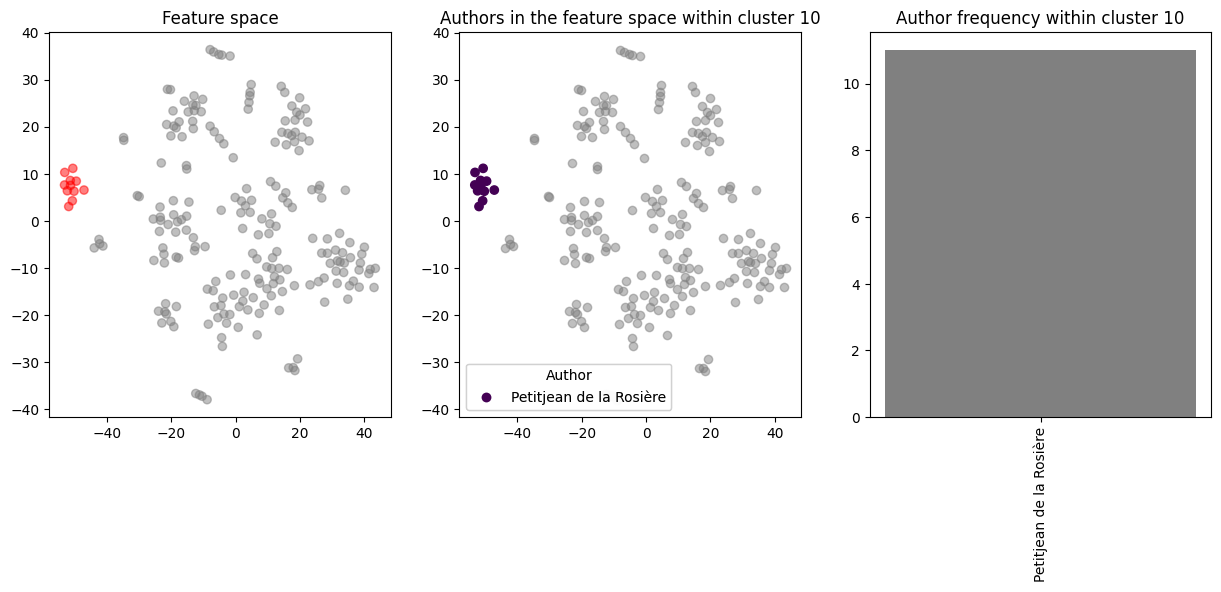

In [31]:
scatter_plot_one_cluster(cluster.embedding, cluster_labels, 10, metadata.data.loc[:, "author"])